# MolRL: Basic Usage - `MolMIM`

To use MolRL with MolMIM please refer to the bionemo documentation on installing the BioNemo image: https://docs.nvidia.com/bionemo-framework/2.0/user-guide/getting-started/initialization-guide/

In [1]:
%load_ext autoreload 
%autoreload 2 

In [2]:
import molrl
import logging
import torch
import pandas as pd
import datamol as dm
import pytorch_lightning as pl 
import matplotlib.pyplot as plt 
import seaborn as sns
from rdkit.Chem import QED, MolFromSmiles
from molrl import SMILESVAERNNCAT, Vocab
from molrl import get_vae_model
from rdkit import Chem

## Define a scoring function

Here we define a simple reward function that checks if a molecule contains an Aminopyrimidine substructure & QED

In [3]:
sub = 'Nc1ncccn1' #Aminpyrimidine substructure 
sub_smarts = Chem.MolFromSmarts(sub)

In [4]:
def contains_substructure_and_qed(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        qed = dm.descriptors.qed(mol)
        if mol.HasSubstructMatch(sub_smarts):
            return 1 + qed
        else:
            return qed 
    except:
        return 0

reward_fn = molrl.BaseRewardSimple(calculator=contains_substructure_and_qed)

In [14]:
# reward_fn([], new_smiles=[sub], original_smiles=None) # Validate reward function

## Load a latent model

Specify your `BIONEMO_HOME` directory and the path to the MolMIM.nemo model `MOLMIM_CHECKPOINTS_PATH` 

In [ ]:
molmim = molrl.MolMIMModel(MOLMIM_CHECKPOINTS_PATH='/home/jovyan/bionemo-models/molecule/molmim/molmim_70m_24_3.nemo',BIONEMO_HOME='/workspace/bionemo')

## Define the actor critc network

In [7]:
actor_critic = molrl.ActorCritic(
        input_dim=molmim.get_latent_size(),
        action_dim=molmim.get_latent_size(),
        hidden_dim=molmim.get_latent_size(),
)

## Initialize the agent 

In [8]:
agent = molrl.PPOAgent(
            latent_model=molmim,
            policy_net_latent=actor_critic,
            reward_fn=reward_fn,
            device="cuda:0",
    )

I1220 23:07:55.146188 140390357430720 ppo.py:208] Initialized PPOAgent on device: cuda:0


## Run optimization 

In [ ]:
agent.train(n_random_seeds=1, 
            batch_size=100, 
            epochs=100, 
            std_decay_rate=0.9996, 
            std=1.0, 
            clip_epsilon=0.9, 
            learning_rate=0.0001, 
            n_top_k=1000,
            update_steps=128)

## Plot optimization results

In [11]:
train_metrics = pd.DataFrame(agent.train_metrics)

<Axes: xlabel='epoch', ylabel='episode_reward'>

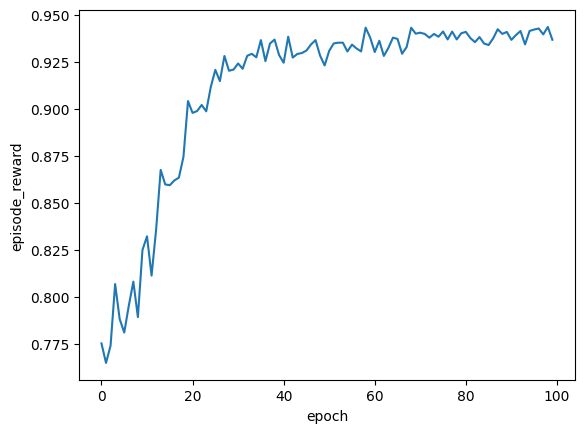

In [12]:
sns.lineplot(x='epoch', y='episode_reward', data=train_metrics)

## Visualize top results

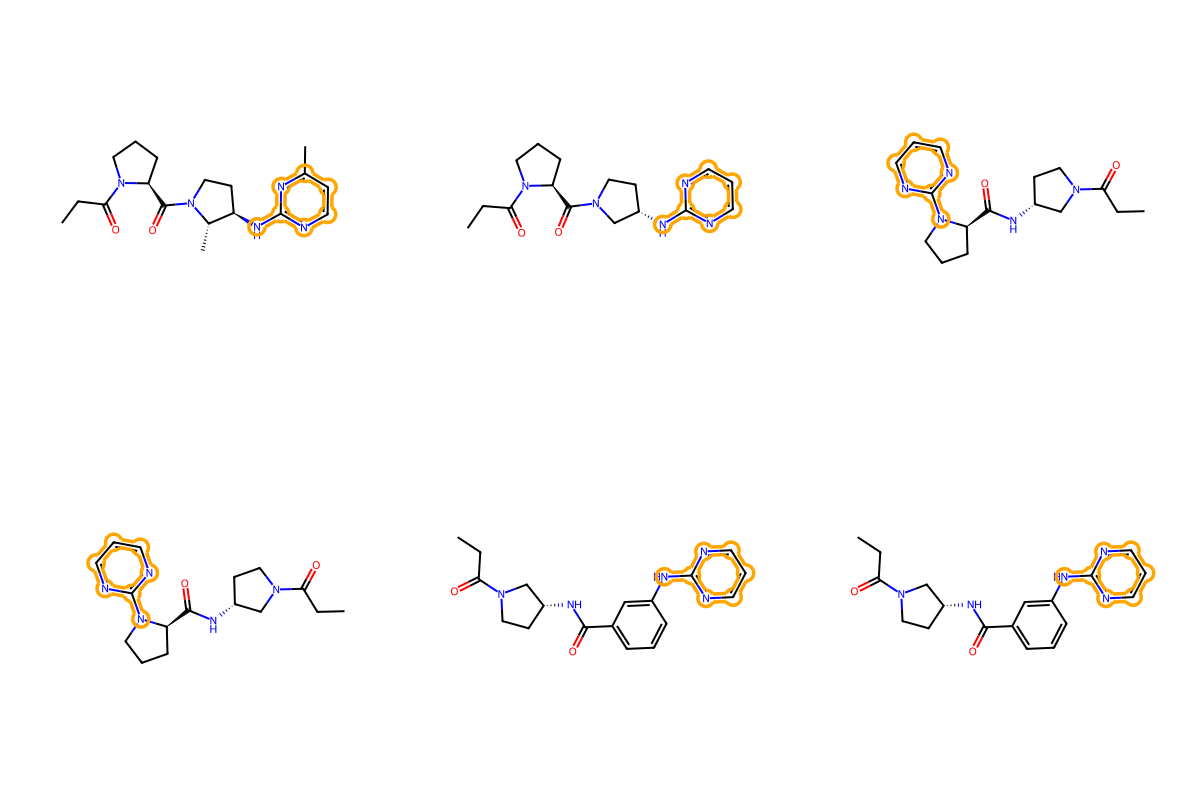

In [13]:
buffer = agent.buffer()
buffer = buffer.sort_values(by='reward', ascending=False)
target_mols = [dm.to_mol(i) for i in buffer.new_smiles.values[0:6]]
search_mols = [sub_smarts]
dm.lasso_highlight_image(target_molecules=target_mols, search_molecules=search_mols, mol_size=(400, 400),n_cols=3,color_list=['orange'], line_width=3.5)